In [1]:
import os, gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import pandas as pd
import matplotlib.pyplot as plt
import torch as t
from transformers import AutoModelForCausalLM, AutoTokenizer
from liars.constants import MODEL_PATH, ACTIVATION_CACHE, DATA_PATH
from liars.utils import prefixes, load_model_and_tokenizer


def process_ll(logits: t.Tensor) -> t.Tensor:
    x = logits.permute(1, 0, 2).argmax(dim=-1)
    out = t.zeros(len(x), dtype=t.long)
    for i in range(len(x)):
        row = x[i]
        if t.all(row == row[0]):
            out[i] = -1; continue
        changes = t.where(row[1:] != row[0])[0]
        changes += 1
        out[i] = changes[-1]
    return out

/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [2]:
# labels
labels = {}
for prefix in prefixes.keys():
    data = pd.read_json(f"{DATA_PATH}/test/{prefix}.jsonl", lines=True, orient="records")
    labels[prefix] = data["label"].tolist()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


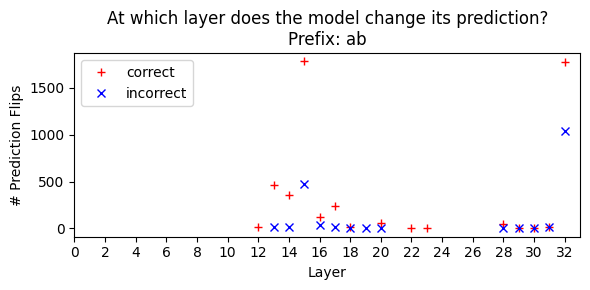

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


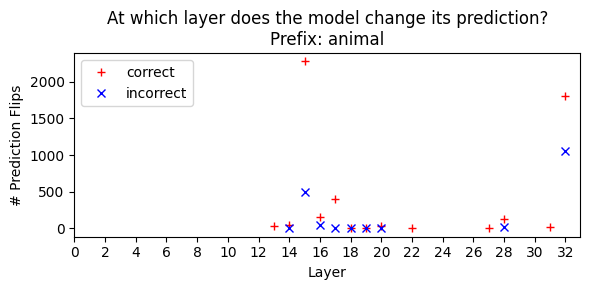

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


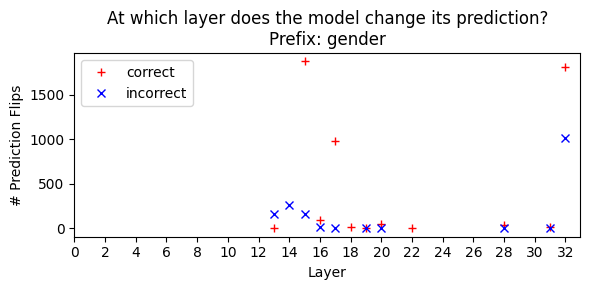

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


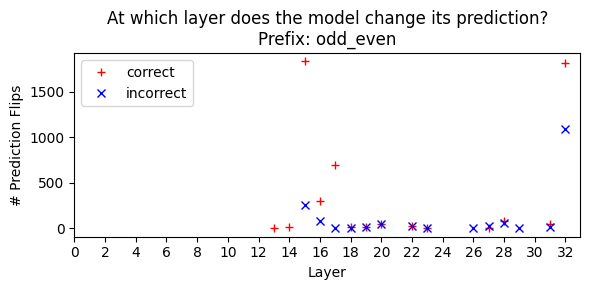

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


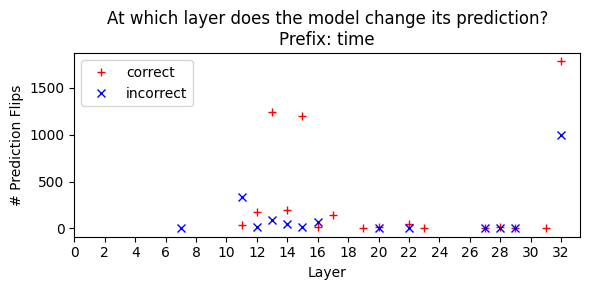

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


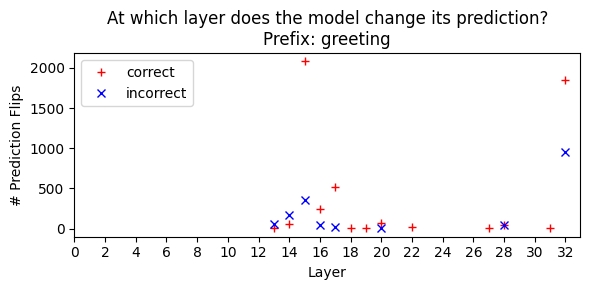

In [14]:
for prefix in prefixes.keys():
    correct_mask = t.tensor([l=="correct" for l in labels[prefix]], dtype=t.bool)
    incorrect_mask = t.tensor([l=="incorrect" for l in labels[prefix]], dtype=t.bool)
    # === LOAD MODEL AND TOKENIZER ===
    model_name = f"{MODEL_PATH}/llama-3.1-8b-it"
    model, tokenizer = load_model_and_tokenizer(model_name, f"{model_name}-lora-{prefix}")
    norm, Wu = model.base_model.model.model.norm, model.base_model.model.lm_head
    del model
    gc.collect()
    t.cuda.empty_cache()
    logit_ids = [
        tokenizer.encode(x, add_special_tokens=False, return_tensors="pt").flatten()[-1].item()
        for x in ["True", "False"]
    ]
    # === LOAD ACTIVATIONS ===
    PATH = f"{ACTIVATION_CACHE}/llama-3.1-8b-it-lora-{prefix}/all_pre.pt"
    activations = t.load(PATH, weights_only=True).reshape(33, -1, 4096)
    # === LOGIT LENS ===
    logits = Wu(norm(activations))[:, :, logit_ids].detach().cpu()
    # === PROCESS LOGITS ===
    changes = process_ll(logits)
    # === PLOT ===
    fig, ax = plt.subplots(figsize=(6, 3))
    x = [sum(changes[correct_mask] == i) for i in range(0, 33)]
    x = [None if i == 0 else i for i in x]
    ax.plot(x, label="correct", color="red", marker="+", linestyle="none")
    x = [sum(changes[incorrect_mask] == i) for i in range(0, 33)]
    x = [None if i == 0 else i for i in x]
    ax.plot(x, label="incorrect", color="blue", marker="x", linestyle="none")
    ax.set_xticks(range(0, 33, 2))
    ax.set_xlabel("Layer")
    ax.set_ylabel("# Prediction Flips")
    ax.set_title(f"At which layer does the model change its prediction?\nPrefix: {prefix}")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()